In [15]:
# modifiy fitness:
#  previous:
#     maximize accuracy

#  now:
#     maximize 0.8*accuracy - 0.2*unwanted_cases

In [16]:
# library for GA
import random

from deap import base
from deap import creator
from deap import tools
from deap import algorithms

# library for RF
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


import pandas as pd
from seaborn import violinplot
import seaborn as sns

In [17]:
spectrum_data = pd.read_excel('./spectrum_data/MIne_Nothing_Rock.xlsx',  sep = ',', header = 0)

In [18]:
spectrum_data[0:5]

,Signal_Path,Frequency_0,Frequency_0dot32541,Frequency_0dot65083,Frequency_0dot97624,Frequency_1dot3017,Frequency_1dot6271,Frequency_1dot9525,Frequency_2dot2779,Frequency_2dot6033,...,Frequency_497dot234,Frequency_497dot5594,Frequency_497dot8848,Frequency_498dot2102,Frequency_498dot5356,Frequency_498dot861,Frequency_499dot1865,Frequency_499dot5119,Frequency_499dot8373,Label
0,1,-1.459259,-4.532056,-32.680765,-34.772452,-37.362220,-41.463815,-41.809600,-41.411157,-42.444672,...,-92.727267,-94.206407,-95.049497,-92.151649,-94.120509,-95.140720,-91.976042,-88.533568,-91.717852,1
1,1,4.928653,1.957394,-35.392737,-42.128736,-46.621402,-53.255708,-56.017699,-59.087885,-62.249034,...,-88.354186,-88.465816,-85.997244,-87.914434,-88.387158,-89.374889,-87.190449,-88.074054,-85.246747,1
2,1,5.429769,2.402802,-39.912158,-40.833904,-43.269220,-44.225699,-43.763521,-44.645556,-46.069485,...,-87.576766,-92.467630,-89.857615,-86.389981,-85.861711,-88.080618,-88.199254,-89.362906,-92.505462,1
3,1,-8.860418,-11.892214,-40.604265,-41.491205,-46.728661,-45.278651,-46.840303,-48.153704,-48.827305,...,-88.342649,-90.868922,-88.491640,-89.537515,-89.388839,-90.235332,-90.477474,-91.199705,-89.209511,1
4,1,-14.143644,-17.023779,-34.837263,-43.262198,-43.991594,-47.693121,-48.950286,-45.364605,-46.008724,...,-90.700178,-93.163671,-93.431828,-90.653285,-93.611234,-90.997471,-89.479312,-87.478921,-90.607241,1


In [19]:
# set algorithm parameters

def run_GA(NUM_TREES, IND_SIZE, POP_SIZE, CX_RATE = 0.8):
    """
    NUM_TREES is the number of trees the random forest model pro
    """    
    MUTATE_RATE = 1.0/IND_SIZE 
    
    
    
    # prepare data
   
    raw = spectrum_data.values

    X = raw[:, 0:1538]
    y = raw[:, 1538]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random.randint(0,5000))
    
    
    model = RandomForestClassifier(n_estimators= NUM_TREES) # create a random forest with NUM_TREES = 20 
    model.fit(X_train, y_train) # train the model
    estimators = model.estimators_ # get all the trees
    
    # implement individual
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    # implement functions for initialize population and create individual
    toolbox = base.Toolbox() # create a toolbox of operators for our GA algorithm
    toolbox.register("indices", random.sample, range(NUM_TREES), NUM_TREES) # this is a helper function for creating
                                                                            # each individual
    toolbox.register("individual", tools.initIterate, creator.Individual,   # this is the function for creating an 
                     toolbox.indices)                                       # individual


    #toolbox.individual()  # a test 

    # implement function for creating a population
    toolbox.register("population", tools.initRepeat, list, toolbox.individual, n = POP_SIZE)

    #toolbox.population()  # a test
    
    def sub_rf_predict(sub_rf, X_test):
        """
        return the predict result using the sub_rf and X_test data;
        the rule is that predict result(labels) with the maximum number of votes wins.
        """
        predict_results = []
        for tree in sub_rf:
            prediction = tree.predict(X_test)
            # record prediction result for a tree
            predict_results.append(prediction)

        # compute the vote_result, i.e. the final result
        y_predict = [0]*len(X_test)
        for idx in range(len(X_test)):
            # for each test data
            # create a vote result
            v_result = vote_result()
            for predict_tree in predict_results:
                v_result[predict_tree[idx]] += 1

            # final result
            y_predict[idx] = keywithmaxval(v_result)

        return  np.array(y_predict, dtype = float)

    # helper function
    y_set = set(y_test).union(y_train)
    def vote_result():
        result = {}
        for k in y_set:
            result[k] = 0
        return result

    def keywithmaxval(d):
        """ a) create a list of the dict's keys and values; 
        b) return the key with the max value"""  
        v=list(d.values())
        k=list(d.keys())
        return k[v.index(max(v))]
    
    
    #  modified fitness function
    def evaluate(individual):
        # return the accuracy on the test data
        sub_random_forest = []
        for tree_idx in individual[0: IND_SIZE]:
            sub_random_forest.append(estimators[tree_idx])

        predict_sub_trees = sub_rf_predict(sub_random_forest, X_test)
        # print(predict_sub_trees.__repr__())
        # score = precision_score(y_test, predict_sub_trees, average = 'macro')
        cf_matrix = evaluate_confusion_matrix(individual)
        
        pseudo_acc_case_rate = (cf_matrix[1, 1] + cf_matrix[0, 0] + cf_matrix[2, 2]) / np.sum(cf_matrix)
        bad_case_rate = (cf_matrix[1, 0] + cf_matrix[1, 2]) / np.sum(cf_matrix)
        undesired_case_rate = (cf_matrix[0, 1] + cf_matrix[2, 1]) / np.sum(cf_matrix)
        
        # give accuracy more weight
        score = 0.4 * pseudo_acc_case_rate - 0.4 * bad_case_rate - 0.2 * undesired_case_rate
        return  score,  # must return an tuple!!!!
    
    def evaluate_confusion_matrix(individual):
        # return the confusion matrix of a model
        sub_random_forest = []
        for tree_idx in individual[0: IND_SIZE]:
            sub_random_forest.append(estimators[tree_idx])

        predict_sub_trees = sub_rf_predict(sub_random_forest, X_test)
        cf_matrix = confusion_matrix(y_test, predict_sub_trees)
        return  cf_matrix 

    
    
    # implement mutation operator
    mutation_op = tools.mutShuffleIndexes
    
    
    # implement crossover
    def crossover_op(ind1, ind2):
        # only cross over the first IND_SIZE elements in the individual in place
        crossover_idx = random.randint(0, IND_SIZE - 2)
        # print(crossover_idx)
        temp = toolbox.clone(ind1[crossover_idx + 1: IND_SIZE])
        ind1[crossover_idx + 1: IND_SIZE] = ind2[crossover_idx + 1: IND_SIZE]
        ind2[crossover_idx + 1: IND_SIZE] = temp
        return (ind1, ind2)
    
    # implement selection operator
    selection_op = tools.selTournament
    
    
    # register everything in our toolbox
    toolbox.register("mate", crossover_op)
    toolbox.register("mutate", mutation_op, indpb = MUTATE_RATE)
    toolbox.register("select", selection_op, tournsize=3)
    toolbox.register("evaluate", evaluate)
    
    
    h_fame = tools.HallOfFame(100) # keep track of the first 100 best individuals and store them in h_fame

    pop = toolbox.population()
    final_pop = algorithms.eaSimple(pop, toolbox, cxpb = CX_RATE, mutpb=MUTATE_RATE, ngen=1000, 
                                    stats = None, halloffame = h_fame, verbose = False)
    
    # accuracy_of_the_best_individual = evaluate(h_fame[0])
    # accuracy_of_the_whole_trees_model = accuracy_score(y_test, model.predict(X_test))
    cf_matrix_RF_model = confusion_matrix(y_test, model.predict(X_test))
    cf_matrix_GA_RF_model = evaluate_confusion_matrix(h_fame[0])
    
    return cf_matrix_GA_RF_model, cf_matrix_RF_model, evaluate_confusion_matrix, h_fame, estimators

In [20]:
def measure_model_performance(C):
    """
    C is a confusion matrix
    accuracy, sensitivity, specificity: the higher the better
    FP_rate: the lower the better
    
    Now, only compute accuracy
    """
    accuracy = (C[0,0] + C[1, 1] + C[2, 2]) / np.sum(C)
    sensitivity = 0
    specificity = 0 
    FP_rate = 0
    
    cf_matrix = C
    pseudo_acc_case_rate = (cf_matrix[1, 1] + cf_matrix[0, 0] + cf_matrix[2, 2]) / np.sum(cf_matrix)
    bad_case_rate = (cf_matrix[1, 0] + cf_matrix[1, 2]) / np.sum(cf_matrix)
    undesired_case_rate = (cf_matrix[0, 1] + cf_matrix[2, 1]) / np.sum(cf_matrix)
        
        # give accuracy more weight
    score = 0.4 * pseudo_acc_case_rate - 0.4 * bad_case_rate - 0.2 * undesired_case_rate
    
    return accuracy, sensitivity, specificity, FP_rate, score

In [21]:
import warnings; warnings.simplefilter('ignore')
num_trees = 100
GA_accuracy_result = []
RF_accuracy_result = []

GA_sensitivity_result = []
RF_sensitivity_result = []

GA_specificity_result = []
RF_specificity_result = []

GA_FP_rate_result = []
RF_FP_rate_result = []

confusion_matrices_list_GA_RF = []
h_fame_list = []
GA_RF_model_list = []

GA_score_list = []

print('num_trees = ', num_trees)
for i in range(50):  # run the experiment 300 times
    print(i)
    cf_matrix_GA_RF_model, cf_matrix_RF_model, evaluate_confusion_matrix, h_fame, estimators = run_GA(num_trees, 10, 30)
    
    GA_accuracy, GA_sensitivity, GA_specificity, GA_FP_rate, GA_score = measure_model_performance(cf_matrix_GA_RF_model)
    RF_accuracy, RF_sensitivity, RF_specificity, RF_FP_rate, RF_score = measure_model_performance(cf_matrix_RF_model)

    GA_accuracy_result.append(GA_accuracy)
    RF_accuracy_result.append(RF_accuracy)

    GA_sensitivity_result.append(GA_sensitivity)
    RF_sensitivity_result.append(RF_sensitivity)

    GA_specificity_result.append(GA_specificity)
    RF_specificity_result.append(RF_specificity)

    GA_FP_rate_result.append(GA_FP_rate)
    RF_FP_rate_result.append(RF_FP_rate)
    
    confusion_matrices_list_GA_RF.append(cf_matrix_GA_RF_model)
    GA_RF_model_list.append(estimators)
    
    GA_score_list.append(GA_score)

num_trees =  100
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [22]:
def show_result():
    print("mean accuracy = ",  np.mean(GA_accuracy_result))
    print("std accuracy = ", np.std(GA_accuracy_result))
    print("Max accuracy = ", np.max(GA_accuracy_result))
    print("confusion Matrix for model with max accuracy is ", confusion_matrices_list_GA_RF[np.argmax(GA_accuracy_result)])
    print("Max score = ", np.max(GA_score_list))
    print("confusion Matrix for model with max score is ", confusion_matrices_list_GA_RF[np.argmax(GA_score_list)])

In [23]:
show_result()

mean accuracy =  0.6733333333333335
std accuracy =  0.05263430792145338
Max accuracy =  0.8
confusion Matrix for model with max accuracy is  [[12  2  2]
 [ 3 12  1]
 [ 0  1 12]]
Max score =  0.2711111111111112
confusion Matrix for model with max score is  [[12  2  2]
 [ 3 12  1]
 [ 0  1 12]]


In [71]:
def convert_to_df(GA_result, RF_result, result_name):
    # first make the list shallow
    GA_result = sum(GA_result, [])
    RF_result = sum(RF_result, [])
    
    num_trees = 50*[20] + 50*[30] + 50*[50]
    num_trees = num_trees + num_trees
    algorithm = 150 * ['GA + RF'] + 150 * ['RF']
    data = GA_result + RF_result
    
    # form the dictionary
    d = {result_name:data, 'algorithm': algorithm, 'num_trees': num_trees}
    
    df = pd.DataFrame(data = d)
    return df

In [72]:
pd_accuracy = convert_to_df(GA_accuracy_final_result,RF_accuracy_final_result , 'accuracy')
# save data
pd_accuracy.to_pickle('.\figure_data\fig(1).pkl')
# load data
x = pd.read_pickle('.\figure_data\fig(1).pkl')

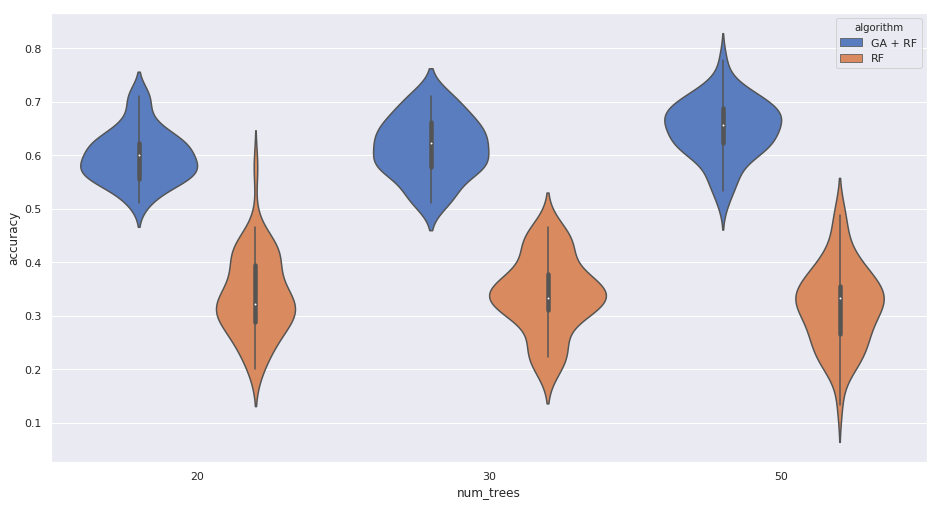

In [73]:
sns.set(rc={'figure.figsize': (15.7, 8.27) })  # set size
fig1 = violinplot(x = 'num_trees', y = 'accuracy', hue = 'algorithm', data = pd_accuracy, palette = 'muted')
fig1_save = fig1.get_figure()
fig1_save.savefig("accuracy_figure.png")

In [10]:
def save_data_and_plot(GA_result, RF_result, result_name, save_file_name, figure_size = (15.7, 8.27)):    
    pd_data = convert_to_df(GA_result,RF_result , result_name)
    # save data
    pd_data.to_csv('./figure_data/{0}.csv'.format(save_file_name))
    
    sns.set(rc={'figure.figsize': figure_size })  # set size
    fig1 = violinplot(x = 'num_trees', y = result_name, hue = 'algorithm', data = pd_data, palette = 'muted')
    fig1_save = fig1.get_figure()
    fig1_save.savefig(save_file_name)

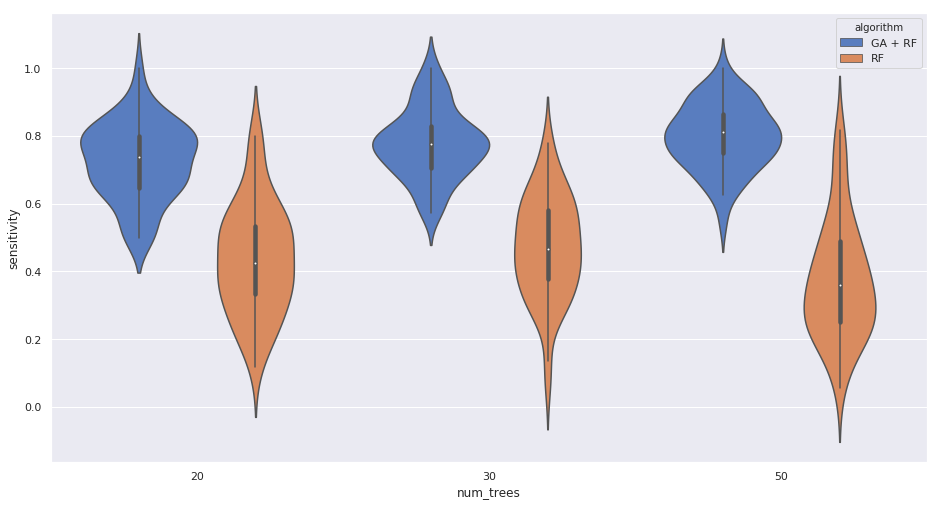

In [11]:
save_data_and_plot(GA_sensitivity_final_result,RF_sensitivity_final_result , 'sensitivity', 'sensitivity_figure.png')

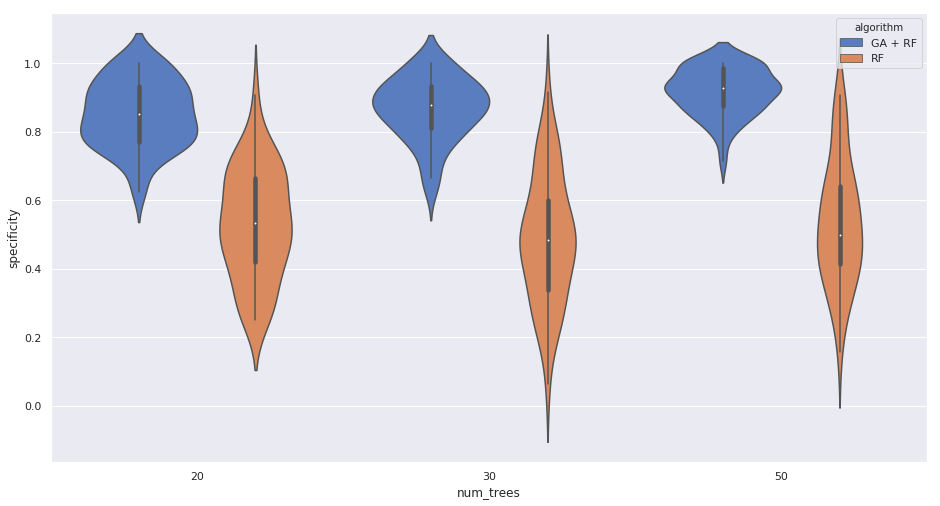

In [12]:
save_data_and_plot(GA_specificity_final_result,RF_specificity_final_result , 'specificity', 'specificity_figure.png')

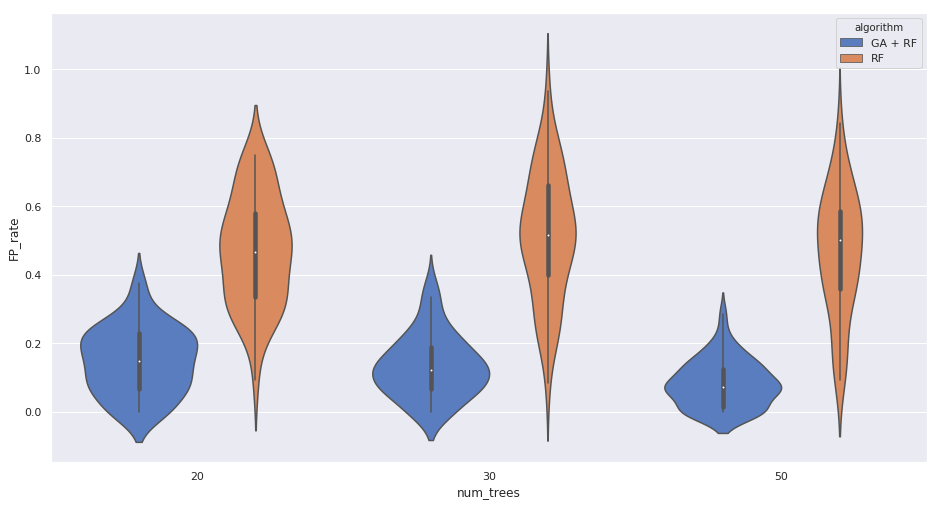

In [13]:
save_data_and_plot(GA_FP_rate_final_result,RF_FP_rate_final_result , 'FP_rate', 'FP_rate_figure.png')